## 자율주행 보조장치 (1)  Dataset : KITTI
---

이번 시간에 만들어 볼 자율주행 보조장치는 카메라에 사람이 탐지되었을 때, 그리고 차가 가까워져서 탐지된 크기가 일정 크기 이상일 때를 판단해야 합니다.

자율주행 보조장치 object detection 요구사항
> - 사람이 카메라에 감지되면 정지
> - 차량이 일정 크기 이상으로 감지되면 정지

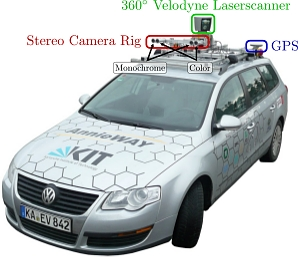

http://www.cvlibs.net/datasets/kitti/

- cvlibs에서 제공하는 KITTI 데이터셋(http://www.cvlibs.net/datasets/kitti/)

먼저 필요한 라이브러리를 불러 옵니다.

In [140]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'


In [120]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

다운로드한 KITTI 데이터셋을 `tfds.show_examples`를 통해 보도록 합시다.

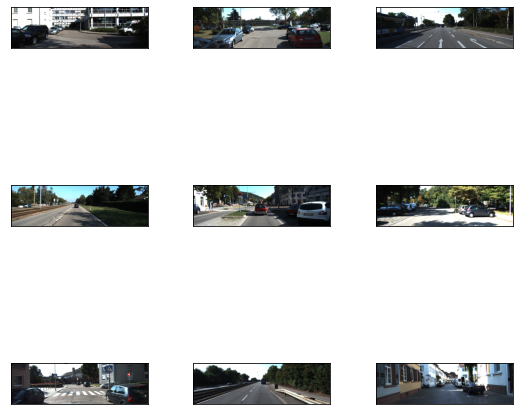

In [44]:
_ = tfds.show_examples(ds_train, ds_info)

데이터 다운로드 시 담아둔 `ds_info`에서는 불러온 데이터셋의 정보를 확인할 수 있습니다. 오늘 사용할 데이터셋은 6,347개의 학습 데이터(training data), 711개의 평가용 데이터(test data), 423개의 검증용 데이터(validation data)로 구성되어 있습니다. 라벨에는 `alpha`, `bbox`, `dimensions`, `location`, `occluded`, `rotation_y`, `truncated` 등의 정보가 있습니다.

In [45]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

## 자율주행 보조장치 (2) 데이터 직접 확인하기
---
이번에는 데이터셋을 직접 확인하는 시간을 갖도록 하겠습니다. `ds_train.take(1)`을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 `sample`을 얻을 수 있습니다. 이렇게 뽑은 데이터에는 `image` 등의 정보가 포함되어 있습니다.

눈으로 확인해서 학습에 사용할 데이터를 직접 이해해 봅시다.



--------Example-----------
['image', 'image/file_name', 'objects']
-------objects---------
{'alpha': <tf.Tensor: shape=(14,), dtype=float32, numpy=
array([-1.97, -1.99, -1.7 , -1.81, -2.11,  2.75,  1.76,  1.93,  1.9 ,
        1.88, -2.99,  1.56,  1.74,  1.67], dtype=float32)>, 'bbox': <tf.Tensor: shape=(14, 4), dtype=float32, numpy=
array([[0.13010696, 0.5862278 , 0.576123  , 0.6344265 ],
       [0.15705882, 0.6571244 , 0.601738  , 0.7072052 ],
       [0.2428075 , 0.19313408, 0.55815506, 0.23378837],
       [0.35665774, 0.5088692 , 0.56002676, 0.5274475 ],
       [0.28037432, 0.6259451 , 0.5853476 , 0.66390955],
       [0.11497326, 0.8804039 , 0.6296524 , 0.97975767],
       [0.2205615 , 0.8873102 , 0.62144387, 0.936042  ],
       [0.27502674, 0.29155898, 0.55122995, 0.32440227],
       [0.24994652, 0.26145396, 0.43826205, 0.3110824 ],
       [0.27093583, 0.26950726, 0.5568984 , 0.2948223 ],
       [0.24264705, 0.86004037, 0.63363636, 0.95084816],
       [0.45516044, 0.42310178, 0.5698

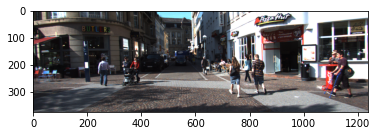

In [46]:
sample = ds_train.take(1)

for example in sample:
    print('--------Example-----------')
    print(list(example.keys()))
    image = example['image']
    filename = example['image/file_name'].numpy().decode('utf-8')
    objects = example['objects']
    
print('-------objects---------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

이미지와 라벨을 얻는 방법을 알게 되었습니다.   
이렇게 얻은 이미지의 바운딩 박스(bounding box, bbox)를 확인하기 위해서는 어떻게 해야 할까요?

KITTI Git에 들어가 데이터셋에 대한 설명을 받아옵니다.

```python

Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.
 ```
 
 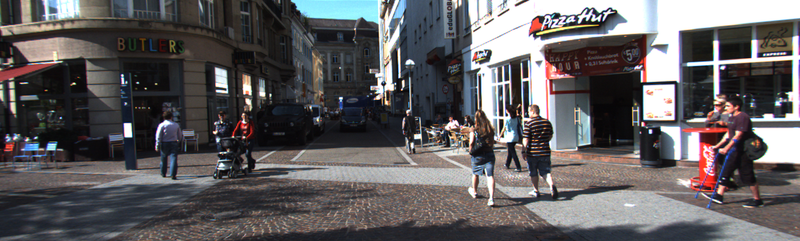
 [KITTI 원본이미지 예시]
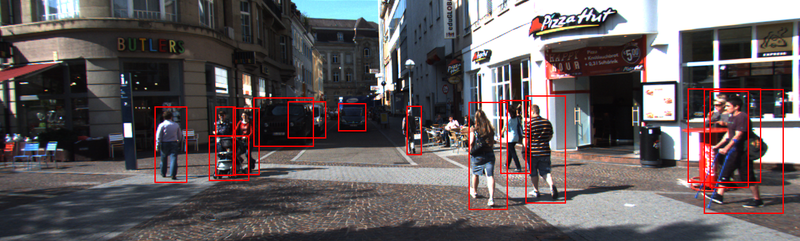
[KITTI 이미지 바운딩 박스 시각화 예시]


- Pillow 라이브러리의 ImageDraw 모듈을 참고하세요.(https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html)



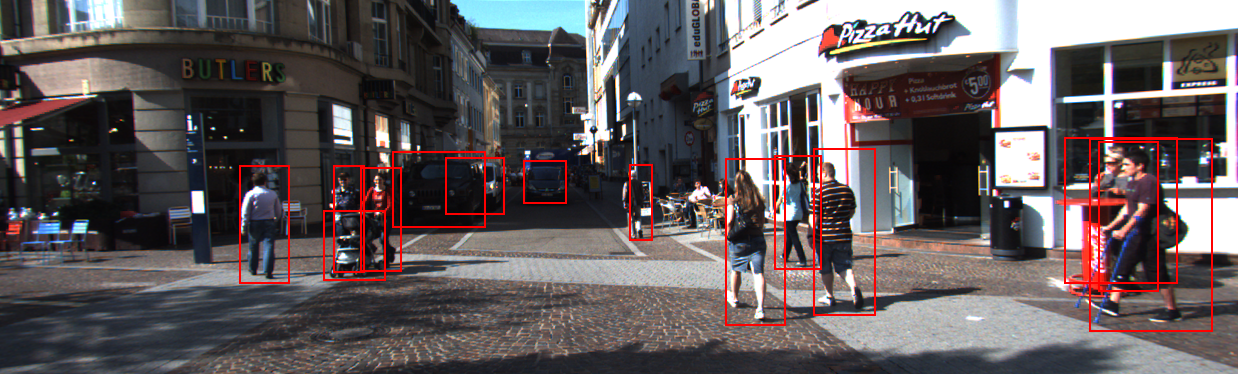

In [47]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    #bounding box 좌표 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width 
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # draw bounding box -> box 형식이 x1,y1 x2,y2라 순서 영향
    rects = np.stack([x_min, y_min, x_max, y_max], axis = 1)
    
    for _rect in rects:
        draw.rectangle(_rect, outline = (255,0,0), width = 2)
        
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

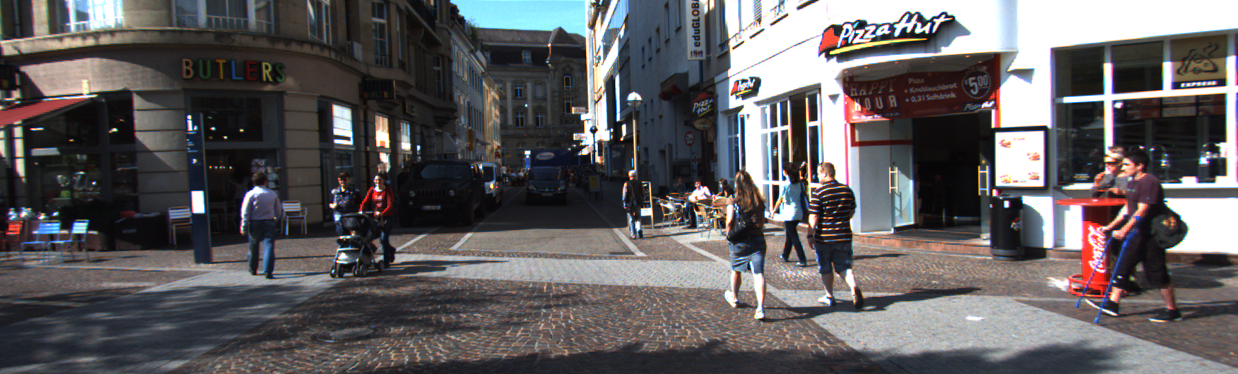

In [48]:
img

In [69]:
objects['bbox'].numpy()

array([[0.13010696, 0.5862278 , 0.576123  , 0.6344265 ],
       [0.15705882, 0.6571244 , 0.601738  , 0.7072052 ],
       [0.2428075 , 0.19313408, 0.55815506, 0.23378837],
       [0.35665774, 0.5088692 , 0.56002676, 0.5274475 ],
       [0.28037432, 0.6259451 , 0.5853476 , 0.66390955],
       [0.11497326, 0.8804039 , 0.6296524 , 0.97975767],
       [0.2205615 , 0.8873102 , 0.62144387, 0.936042  ],
       [0.27502674, 0.29155898, 0.55122995, 0.32440227],
       [0.24994652, 0.26145396, 0.43826205, 0.3110824 ],
       [0.27093583, 0.26950726, 0.5568984 , 0.2948223 ],
       [0.24264705, 0.86004037, 0.63363636, 0.95084816],
       [0.45516044, 0.42310178, 0.5698396 , 0.45743135],
       [0.39173797, 0.31714863, 0.59502673, 0.3922698 ],
       [0.4271123 , 0.36006463, 0.5799733 , 0.40741518]], dtype=float32)

```
#bounding box 좌표 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width 
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
```
상기 bounding box 좌표를 구할 때 x 값에 width를 곱하는게 왜그런가 봤더니 bounding box의 값은 0~1의 값으로 나와 거기에 width를 곱해 이미지에 입히는 것 같습니다!

## RetinaNet
- Focal Loss for Dense Object Detection(https://arxiv.org/pdf/1708.02002.pdf)
RetinaNet은 Focal Loss for Dense Object Detection 논문을 통해 공개된 detection 모델입니다.

1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 가지고 있었습니다. 이를 해결하기 위해서 RetinaNet에서는 focal loss와 FPN(Feature Pyramid Network) 를 적용한 네트워크를 사용합니다.

### Focal Loss
---
> 물체를 배경보다 더 잘 학습하자 == 물체인 경우 Loss를 작게 만들자

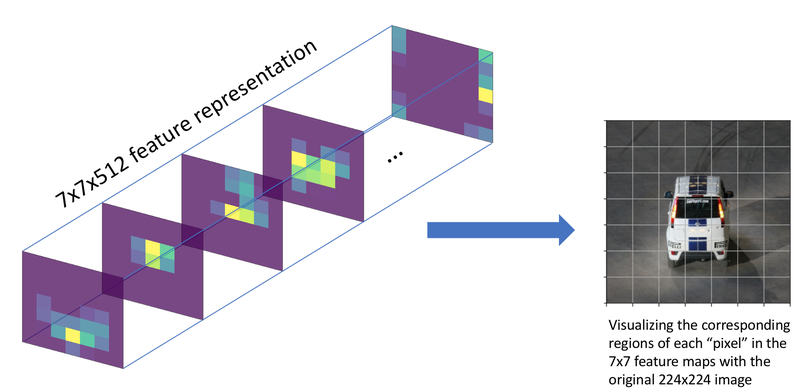  
https://www.jeremyjordan.me/object-detection-one-stage/


Focal loss는 기존의 1-stage detection 모델들(YOLO, SSD)이 물체 전경과 배경을 담고 있는 모든 그리드(grid)에 대해 한 번에 학습됨으로 인해서 생기는 클래스 간의 불균형을 해결하고자 도입되었습니다. 여기서 그리드(grid)와 픽셀(pixel)이 혼란스러울 수 있겠는데, 위 그림 왼쪽 7x7 feature level에서는 한 픽셀이고, 오른쪽의 image level(자동차 사진)에서 보이는 그리드는 각 픽셀의 receptive field입니다.

그림에서 보이는 것처럼 우리가 사용하는 이미지는 물체보다는 많은 배경을 학습하게 됩니다. 논문에서는 이를 해결하기 위해서 Loss를 개선하여 정확도를 높였습니다.

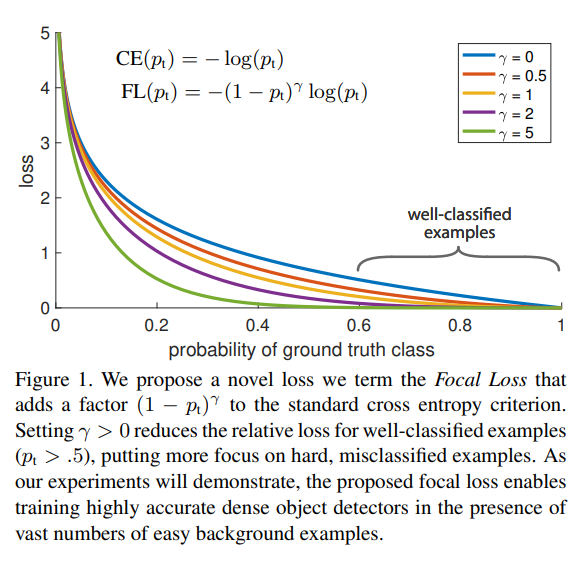

https://arxiv.org/abs/1708.02002


Focal loss는 우리가 많이 사용해왔던 교차 엔트로피를 기반으로 만들어졌습니다. 위 그림을 보면 Focal loss는 그저 교차 엔트로피 $CE(p_t)$의 앞단에 간단히 $(1-p_t)^\gamma$라는 modulating factor를 붙여주었습니다.

교차 엔트로피의 개형을 보면 ground truth class에 대한 확률이 높으면 잘 분류된 것으로 판단되므로 손실이 줄어드는 것을 볼 수 있습니다. 하지만 확률이 1에 매우 가깝지 않은 이상 상당히 큰 손실로 이어지는데요.

이 상황은 물체 검출 모델을 학습시키는 과정에서 문제가 될 수 있습니다. 대부분의 이미지에서는 물체보다 배경이 많습니다. 따라서 이미지는 극단적으로 배경의 class가 많은 class imbalanced data라고 할 수 있습니다. 이렇게 너무 많은 배경 class에 압도되지 않도록 modulating factor로 손실을 조절해줍니다.$\gamma$를 0으로 설정하면 modulating factor $(1-p_t)^\gamma$가 1이 되어 일반적인 교차 엔트로피가 되고 $\gamma$가 커질수록 modulating이 강하게 적용되는 것을 확인할 수 있습니다.


### FPN(Feature Pyramid Network)
---
> 여러 층의 특성 맵(feature map)을 다 사용해보자

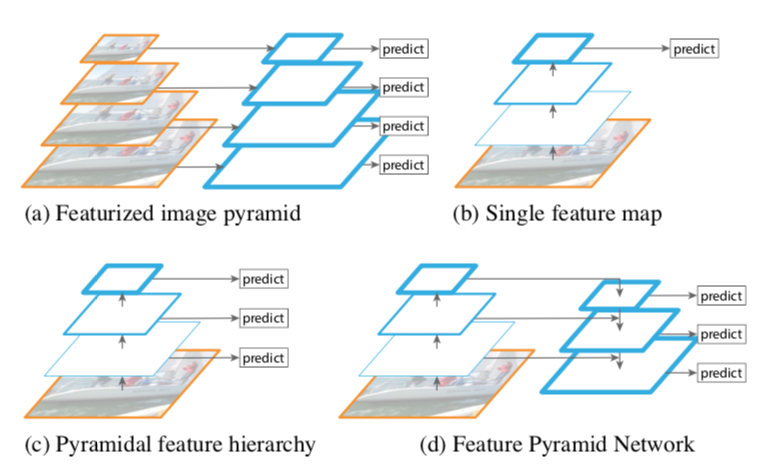
https://arxiv.org/abs/1612.03144

FPN은 특성을 피라미드처럼 쌓아서 사용하는 방식입니다. CNN 백본 네트워크에서는 다양한 레이어의 결과값을 특성 맵(feature map)으로 사용할 수 있습니다. 이때 컨볼루션 연산은 커널을 통해 일정한 영역을 보고 몇 개의 숫자로 요약해 내기 때문에, 입력 이미지를 기준으로 생각하면 입력 이미지와 먼 모델의 뒷쪽의 특성 맵일수록 하나의 "셀(cell)"이 넓은 이미지 영역의 정보를 담고 있고, 입력 이미지와 가까운 앞쪽 레이어의 특성 맵일수록 좁은 범위의 정보를 담고 있습니다. 이를 receptive field라고 합니다. 레이어가 깊어질 수록 pooling을 거쳐 넓은 범위의 정보(receptive field)를 갖게 되는 것입니다.

FPN은 백본의 여러 레이어를 한꺼번에 쓰겠다라는데에 의의가 있습니다. SSD가 각 레이어의 특성 맵에서 다양한 크기에 대한 결과를 얻는 방식을 취했다면 RetinaNet에서는 receptive field가 넓은 뒷쪽의 특성 맵을 upsampling(확대)하여 앞단의 특성 맵과 더해서 사용했습니다. 레이어가 깊어질수록 feature map의 ww, hh방향의 receptive field가 넓어지는 것인데, 넓게 보는 것과 좁게 보는 것을 같이 쓰겠다는 목적인 거죠.

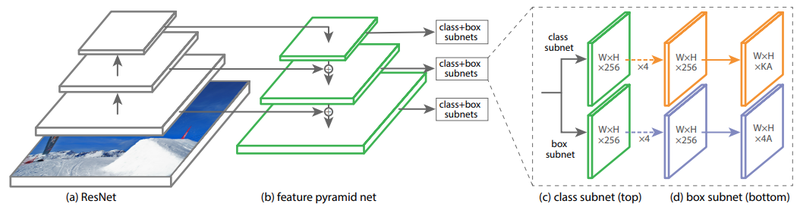

https://arxiv.org/abs/1708.02002


위 그림은 RetinaNet 논문에서 FPN 구조가 어떻게 적용되었는지를 설명하는 그림입니다. RetinaNet에서는 FPN을 통해 $P_3$부터 $P_7$까지의 pyramid level을 생성해 사용합니다. 각 pyramid level은 256개의 채널로 이루어지게 됩니다. 이를 통해 Classification Subnet과 Box Regression Subnet 2개의 Subnet을 구성하게 되는데, Anchor 갯수를 A라고 하면 최종적으로 Classification Subnet은 K개 class에 대해 KA개 채널을, Box Regression Subnet은 4A개 채널을 사용하게 됩니다.

## 데이터 준비

### 데이터 파이프 라인
---
먼저 주어진 KITTI 데이터를 학습하기에 알맞는 형태로 바꿔주어야합니다. 데이터 파이프라인을 구축해봅니다.

데이터 파이프라인은 총 4단계로 이루어집니다.

1.  x와 y좌표 위치 교체
2. 무작위로 수평 뒤집기(Flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정


각 단계별 독립적인 함수를 작성해봅시다!



In [50]:
# 1. x, y 좌표 위치 재설정
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis = -1)

기존 kitti 데이터 좌표형태 -> [x_min, y_min, x_max, y_max]로 변경해줌

In [51]:
# 2. 무작위 수평 뒤집기 
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

수평을 뒤집은 다음에 box 또한 같이 뒤집어 줘야합니다!    

각 위치 뿐만 아니라 x_max였던 좌표가 x_min으로 변경되니 위치도 바꿔줘야합니다.

In [52]:
# 3. 이미지 resize, 패딩 추가
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
        
    ratio = min_side / tf.reduce_min(image_shape)
    
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
        
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    
    return image, image_shape, ratio

이미지 크기를 바꿀 때는 고려할 점이 있습니다. 이미지의 비율은 그대로 유지되어야 하고, 이미지의 최대/최소 크기도 제한해야 하거든요. 또 이미지의 크기를 바꾼 후에도 최종적으로 모델에 입력되는 이미지의 크기는 stride의 배수가 되도록 만들 거예요.

예를 들어 600x720 크기의 이미지가 있다면 800x960 크기로 바꿀 수 있습니다. 여기에 stride를 128로 놓아 800x960 크기의 이미지에 패딩을 더해 896x1024 크기의 이미지로 모델에 입력하겠다는 이야깁니다. 모델에 입력되는 이미지에는 검정 테두리가 있겠군요!

실제로 입력할 이미지를 어떻게 바꿀지는 min_side, max_side, min_side_range, stride등에 의해 결정돼요. 그리고 학습이 완료된 모델을 사용할 때는 입력할 이미지를 다양한 크기로 바꿀 필요는 없으니 분기처리를 해줍니다.

In [53]:
# 4. 좌표계 [x_min, y_min, width, height](detectmodel Type)으로 수정
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [54]:
# 이제 준비된 함수들을 연결해 줍니다.
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

이렇게 만들어진 함수를 통해 image, bbox, class_id(type)까지 받아오게 되었습니다!

### 인코딩
---
R-CNN 시리즈처럼 2step detector가 아닌, 1 stage detector에서는 Anchor Box를 사용하게 됩니다. 

Anchor Box는 1 grid 내에서 2개 이상의 Overlapping object를 분류할때 사용되는 것으로 object의 위치를 Anchor Box라는 정해진 위치, 크기, 비율 중에 하나로 결정하는 것입니다. 

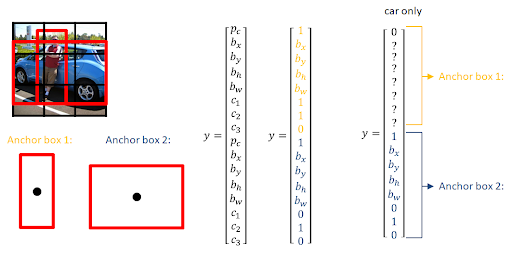
[Andrew Ng 교수님 C4W3L08 Anchor Boxes 참고]

Anchor Box는 algorithm을 통해 grid cell의 y값으로 object의 중심점과 box w, h가 나오게 되는데, 이는 물체의 bounding box 후부들이라고 생각하면 됩니다. 1개의 물체에 여러개의 Anchor Box가 생성되고, 그 중 실제 ground truth와 objec사이의 IOU값이 가장 높은 Anchor Box가 object의 bounding box가 됩니다. 
추가로 Anchor Box로부터 상하좌우로 떨어진 정도, 가로 세로의 크기 차이를 미세하게 찾아내죠. 게다가 Anchor Box가 촘촘하게 겹치도록 생성되기 때문에 물체를 잘 찾아낼 수 있습니다.

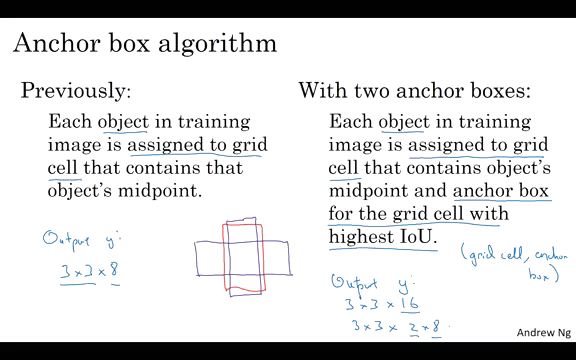

또, RetinaNet에서는 FPN(Feature Pyramid Network)을 사용하기 때문에 Anchor Box가 더 많이 필요합니다. FPN의 각 층마다 Anchor Box가 필요하기 때문입니다. RetinaNet의 FPN에서 pyramid level은 개수가 미리 약속되어 있기 때문에 각 level에서 만들어지는 Anchor Box도 약속되어 있습니다.

이번 프로젝트에서는 논문과 같은 형태로 Anchor Box를 생성합니다.

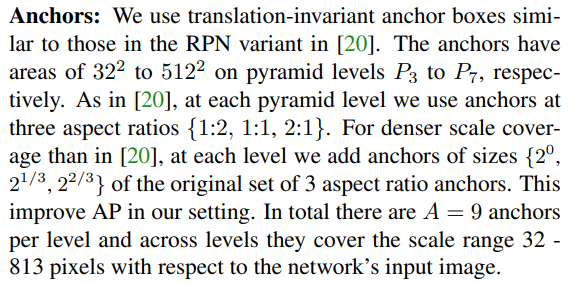

https://arxiv.org/pdf/1708.02002.pdf


In [68]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]
        
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('엥커박스 겟!')

엥커박스 겟!


Anchor Box를 생성하는 함수를 구현했습니다. 그럼 입력 데이터도 그에 맞춰 변형해줘 봅니다.

앞서 Anchor Box에서 bounding box를 선정할 때 IOU를 사용한다고 언급했습니다. 하지만 아직 모델에는 IOU를 넣어 학습할 수 있는 것이 없습니다. 따라서 IOU를 계산할 수 있는 함수를 만들어 줍니다!


#### 참고 IOU란? Intersection over Union

이름 그대로    
- 교집합 영역 넓이 = 예측 면적 ∩ ground truth bbox의 면적
- 합집합 영역 넓이 = 예측 면적 ∪ ground truth bbox의 면적
을 구하여 

IoU = 교집합 영역 넓이 / 합집합 영역 넓이 를 의미합니다.
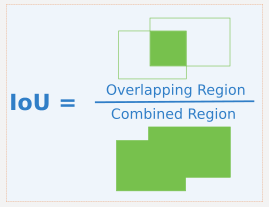

보통 IoU 값의 기준을 0.5로 둔다고 합니다. (정확한 수학적 정의는 없다고함)
하지만 두 box의 크기가 동일하다 가정하면, 두 개의 box가 적어도 2/3는 겹쳐줘야 0.5의 값이 나오기 때문에 여러 곳에서 IoU의 값을 0.5로 잡아서 사용하는 듯 합니다. 

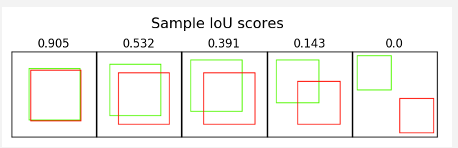

하지만 이 값은 모델의 성능 지표로 사용되는 것은 아니고 Object Detection 부분에서 detection box를 선정하는 과정에서 사용되는 지표입니다.

보통 0.5이지만, 더 높이기 위해서 0.6정도로 잡는 경우도 있다고 합니다.


In [71]:
def convert_to_corners(boxes):
    # 양 끝점으로 바꿔주기
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    
    intersection = tf.maximum(0.0, rd - lu)
    # intersection area 구하기 
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    
    # union area 구하기 
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

print('IoU 구하기 완료')

IoU 구하기 완료


이제 실제 라벨과 Anchor Box를 맞추는 Encoder 클래스를 만들어 줍니다.

위의 
1. compute_iou 함수를 이용해서 IoU를 구하고
2. 그 IoU를 기준으로 물체에 해당하는 Anchor Box와 배경이 되는 Anchor Box를 지정합니다.
3. 그 Anchor Box와 실제 Bounding Box의 미세한 차이를 계산합니다. 
(상하좌우의 차이, 가로세로 크기의 차이를 기록해 두는데 가로세로 크기는 로그를 사용해서 기록해 둡니다.)

이렇게 Anchor Box와 Bounding Box의 차이를 계산함으로 더욱 정교한 예측을 할 수 있게 됩니다.

> 이 과정에서 `variance`가 등장하는데 관례적으로 Anchor Box를 사용할 때 등장하는 변수입니다.   
> 또한 정확한 수학적 이유는 없지만 상하좌우의 차이에는 0.1, 가로세로 크기의 차이에는 0.2를 사용합니다.   
> 이와 관련하여 통계적 추정치를 계산할 때 분산으로 나눠주는 것 때문이라는 의견도 있습니다....

이 과정이 데이터를 훈련 데이터로 바꿔 넣어주는 encoder와 유사하여 LabelEncoder라는 이름으로 클래스를 만들었습니다.

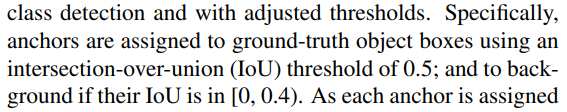  
[IoU가 0.5보다 높으면 물체, 0.4보다 낮으면 배경입니다]  
https://arxiv.org/pdf/1708.02002.pdf

In [78]:
class LabelEncoder:
    def __init__(self):
        #클래스안에 클래스도 넣었다
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    # IOU값을 통한 AnchorBox 구분
    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        # Anchor Box와 실제 Bounding Box의 차이 계산
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    # 이미지 1개짜리 encoder
    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    # 훈련을 위한 batch size encoder 
    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
print('데이터 처리용 클래스 완성!')

데이터 처리용 클래스 완성!


이제 상기 Encdoer class를 통해 데이터를 모델이 학습 가능한 형태로 바꿔 줄 수 있게 되었으니 모델을 만들러 가봅시다.

## 모델 작성

### Feature Pyramid
---
앞서 설명했듯이 RetinaNet에서는 FPN(Feature Pyramid Network)를 사용합니다. 완전히 동일한 것은 아니고 약간 수정해서 사용했습니다. 자세한 설명은 아래에 나와있네요.

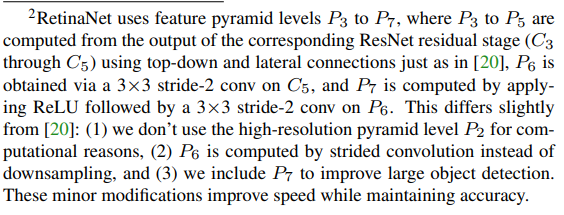
[FPN을 약간 수정합니다]   
https://arxiv.org/pdf/1708.02002.pdf


In [79]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)
        
    # 모델 생성
    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('FPN 모델 완료')

FPN 모델 완료


Object Detection의 라벨은 class와 box로 이루어지므로 각각을 추론하는 부분이 필요합니다. 그것을 head라고 부르기도 합니다. Backbone에 해당하는 네트워크와 FPN을 통해 pyramid layer가 추출되고 나면 그 feature들을 바탕으로 class를 예상하고, box도 예상합니다. class와 box가 모두 맞을 수도, class와 box 중 하나만 맞을 수도, 둘 다 틀릴 수도 있겠죠? class를 예측하는 head와 box를 예측하는 head가 별도로 존재한다는 것이 중요합니다.

그래서 각각의 head를 만들어 줍니다. head부분은 유사한 형태로 만들 수 있으니 build_head라는 함수를 하나만 만들고 두 번 호출하면 될 것 같네요.

In [86]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

우리가 만들 RetinaNet의 backbone은 ResNet50입니다. FPN에 이용할 수 있도록 중간 레이어도 output으로 연결해 줍니다.

In [87]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )


이제 RetinaNet을 완성해 봅니다.

Backbone + FPN + classification용 head + box용 head 입니다.

In [88]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('RetinaNet 생성 완료')

RetinaNet 생성 완료


이제 모델을 준비했고, Loss에 대한 준비를 해봅시다.

RetinaNet에서는 Focal Loss를 사용하는데요. Box Regression에는 사용하지 않고 Classification Loss를 계산하는데만 사용됩니다. Box Regression에는 Smooth L1 Loss를 사용했네요.

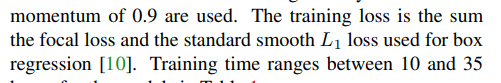
[Focal Loss + Smooth L1 Loss]   
https://arxiv.org/pdf/1708.02002.pdf
Smooth L1 Loss을 사용하는 Box Regression에는 delta를 기준으로 계산이 달라지고, Focal Loss를 사용하는 Classification에서는 alpha와 gamma를 사용해서 물체일 때와 배경일 때의 식이 달라지는 점에 주의하세요!



In [89]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('RetinaNet boxloss, classification loss를 이용한 전체 model loss 완성')

RetinaNet boxloss, classification loss를 이용한 전체 model loss 완성


## 모델 학습
---
앞에서 만들어 놓은 클래스와 함수를 이용해서 모델을 조립하고 학습시켜 봅시다

In [85]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

print('resnet50을 이용한 model 생성 완료')

resnet50을 이용한 model 생성 완료


pretrain resnet 50을 불러 간단하게 model을 만들었습니다! 

다음으로 Learning Rate입니다. 논문에서는 8개의 GPU를 사용했기 때문에 제 구동 환경과는 맞지 않아 적절하게 Learning Rate를 바꿔줍니다.

Optimizer는 논문과 동일하게 SGD를 사용합니다.

In [90]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)

In [91]:
# 모델 컴파일 
model.compile(loss=loss_fn, optimizer=optimizer)

이제 데이터 전처리를 위한 파이프라인도 만들어 줍니다.

In [96]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)
autotune = tf.data.AUTOTUNE


In [97]:
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

print('train dataset 처리 완료')

train dataset 처리 완료


In [98]:
val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

print('validation dataset 처리 완료')

validation dataset 처리 완료


이제 학습을 시켜봅시다.

In [67]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints2/'

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint
    (
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 3

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/3
3173/3173 [==============================] - 1591s 499ms/step - loss: 1.0015 - val_loss: 1.2057

Epoch 00001: saving model to /aiffel/aiffel/object_detection/data/checkpoints2/weights_epoch_1
Epoch 2/3
3173/3173 [==============================] - 1593s 498ms/step - loss: 0.7220 - val_loss: 1.1813

Epoch 00002: saving model to /aiffel/aiffel/object_detection/data/checkpoints2/weights_epoch_2
Epoch 3/3
3173/3173 [==============================] - 1591s 499ms/step - loss: 0.5799 - val_loss: 1.0513

Epoch 00003: saving model to /aiffel/aiffel/object_detection/data/checkpoints2/weights_epoch_3


## 결과 확인하기
---
어떤 식으로 출력되는지 보기 위해 먼저, 학습된 모델을 불러옵시다.

In [82]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

print('pretrain model 불러오기 완료')

pretrain model 불러오기 완료


모델의 추론 결과를 처리할 함수를 레이어 형식으로 만들어 줍니다.   
논문에서는 1000개의 후보를 골라 처리했지만 실습에선 100개의 후보만 골라 처리하도록 합니다. 나머지 설정은 논문과 동일하게 진행하겠습니다.

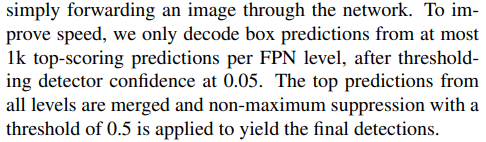
[0.05보다 높은 box 1000개를 골라 0.5 NMS를 진행합니다]  
https://arxiv.org/pdf/1708.02002.pdf

NMS(Non-Max Suppression)은 직접 구현하지 않고 주어진 `tf.image.combined_non_max_suppression`를 사용했습니다.

- tf.image.combined_non_max_suppression(https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)

위의 `nmsed_boxes`, `nmsed_scores`, `nmsed_classes`, `valid_detections`이 각각 무엇인지 알아야 활용할 수 있습니다.



In [83]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

print('box prediction class 완성')

box prediction class 완성


#### 참고 ) NMS(Non-Max Suppression)란?

대다수의 object detection algorithm은 object가 존재하는 위치 주변에 여러개의 score가 높은 bounding box를 만든다는 문제점이 있습니다. 이 중 하나의 bounding box만을 선택해야 하는데, 이때 적용하는 기법이 non-max suppression 입니다. 즉, Non-Maximum Suppression은 object detector가 예측한 bounding box 중에서 정확한 bounding box를 선택하도록 하는 기법입니다. optimal 한 solution일 수는 없고 local maxima를 찾는 방법이라고 볼 수 있습니다.

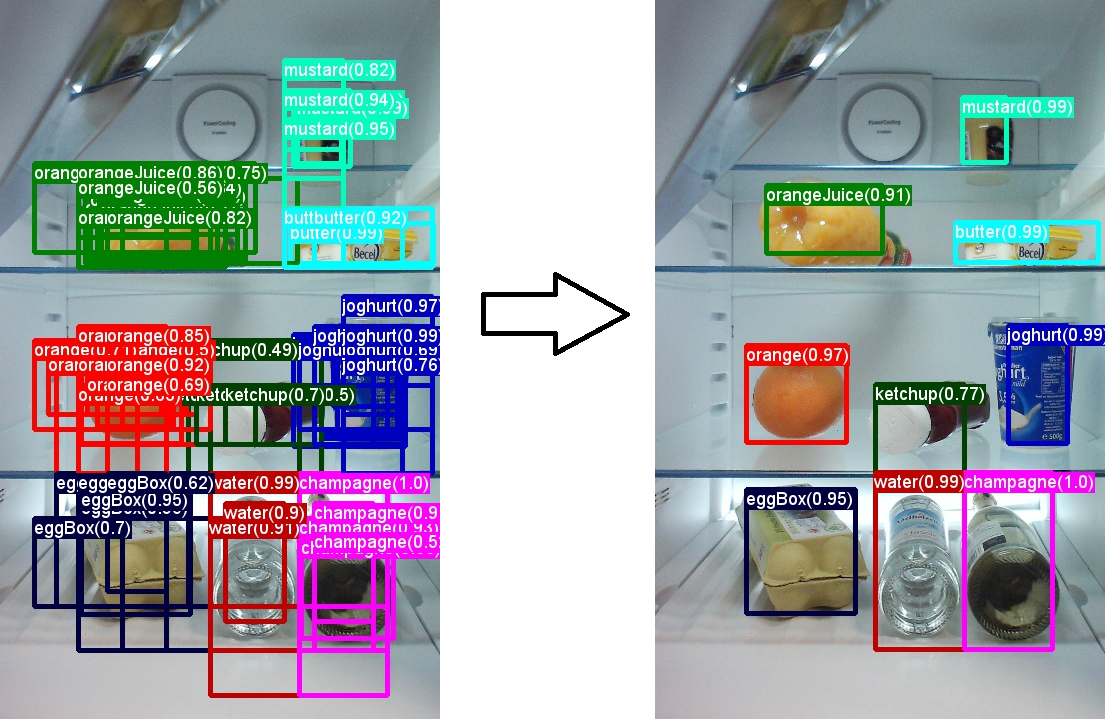

##### NMS의 과정
1. 모든 Bounding box는 자신이 해당 객체를 얼마나 잘 잡아내지 나타내는 confidence score를 가집니다. 모든 bounding box에 대하여 threshold 이하의 confidence score를 가지는 Bounding Box는 제거합니다. Confidence score가 일정 수준 이하인 bounding box들에 대해 일차적으로 필터링을 거치는 과정입니다.
2. 남은 Bounding Box들을 Confidence score 기준 모두 내림차순 정렬합니다.
3. 맨 앞에 있는 Bounding box 하나를 기준으로 잡고, 다른 bounding box와 IoU 값을 구합니다. IoU가 threshold 이상인 Bounding box들은 제거합니다. Bounding box끼리 IoU가 높을수록, 즉 많이 겹쳐질수록 같은 물체를 검출하고 있다고 판단하기 때문입니다.
4. 해당 과정을 순차적으로 시행하여 모든 Bounding box를 비교하고 제거합니다.
5. Confidense threshold가 높을수록, IoU threshold가 낮을수록 더 많은 bounding box가 제거됩니다.


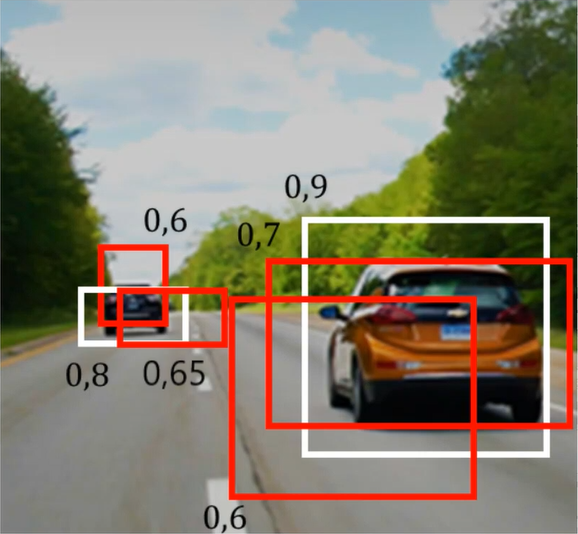

- [Andrew Ng C4W3L07 Non max Suppression](https://www.youtube.com/watch?v=VAo84c1hQX8)
- [한땀한땀 딥러닝 컴퓨터 비전 백과사전](https://wikidocs.net/142645)

In [84]:
# 이제 추론이 가능한 모델을 조립합니다.

image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

print('model 조립 완료')

model 조립 완료


모델의 detection 결과를 시각화 할 함수를 만들어 줍니다.

In [99]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('결과 추론 시각화 함수 완료')

결과 추론 시각화 함수 완료


이제 test시에 입력 데이터를 전처리하기 위한 함수를 만들어봅니다.

Model train을 위한 전처리와 test를 위한 전처리가 다르기 때문에 따로 작성합니다. 

후... 어렵네용....

In [101]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

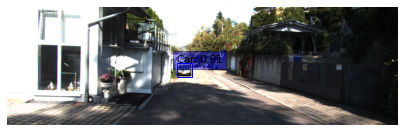

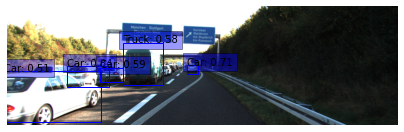

In [100]:
# test 결과 확인
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

묶어서는 확인하기 어려우니 하나하나 열어 결과값을 확인해봅니다

In [112]:
image = tf.cast(sample["image"], dtype=tf.float32)

image

<tf.Tensor: shape=(376, 1241, 3), dtype=float32, numpy=
array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [  9.,  14.,   4.],
        [  9.,  17.,  11.],
        [ 11.,  20.,  16.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [ 15.,  17.,   6.],
        [ 16.,  18.,  11.],
        [ 15.,  19.,  12.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [ 13.,  13.,   7.],
        [ 12.,  13.,   8.],
        [ 10.,  11.,   9.]],

       ...,

       [[ 27.,  24.,  28.],
        [ 26.,  26.,  28.],
        [ 25.,  28.,  31.],
        ...,
        [ 21.,  23.,  16.],
        [ 21.,  23.,  16.],
        [ 21.,  23.,  20.]],

       [[ 20.,  23.,  28.],
        [ 23.,  25.,  28.],
        [ 22.,  25.,  31.],
        ...,
        [ 17.,  24.,  21.],
        [ 17.,  22.,  20.],
        [ 16.,  22.,  20.]],

       [[ 21.,  

In [113]:
input_image, ratio = prepare_image(image)

print(input_image, ratio)

tf.Tensor(
[[[[ 151.061    138.22101  131.32   ]
   [ 151.061    138.22101  131.32   ]
   [ 151.061    138.22101  131.32   ]
   ...
   [-103.939   -116.779   -123.68   ]
   [-103.939   -116.779   -123.68   ]
   [-103.939   -116.779   -123.68   ]]

  [[ 151.061    138.22101  131.32   ]
   [ 151.061    138.22101  131.32   ]
   [ 151.061    138.22101  131.32   ]
   ...
   [-103.939   -116.779   -123.68   ]
   [-103.939   -116.779   -123.68   ]
   [-103.939   -116.779   -123.68   ]]

  [[ 151.061    138.22101  131.32   ]
   [ 151.061    138.22101  131.32   ]
   [ 151.061    138.22101  131.32   ]
   ...
   [-103.939   -116.779   -123.68   ]
   [-103.939   -116.779   -123.68   ]
   [-103.939   -116.779   -123.68   ]]

  ...

  [[-103.939   -116.779   -123.68   ]
   [-103.939   -116.779   -123.68   ]
   [-103.939   -116.779   -123.68   ]
   ...
   [-103.939   -116.779   -123.68   ]
   [-103.939   -116.779   -123.68   ]
   [-103.939   -116.779   -123.68   ]]

  [[-103.939   -116.779   -123.68 

In [138]:
detections.nmsed_boxes[0][:num_detections]/ ratio

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[189.20807 , 120.55629 , 323.03394 , 186.29686 ],
       [572.1925  , 163.4417  , 605.0675  , 190.73993 ],
       [295.91647 , 137.9851  , 365.85327 , 182.29012 ],
       [366.89862 , 126.410995, 492.9877  , 261.68912 ],
       [-10.410455,  10.556929, 296.1989  , 171.47508 ]], dtype=float32)>

In [118]:
num_detections = detections.valid_detections[0]
num_detections

5

In [115]:
class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
class_names

['Car', 'Car', 'Car', 'Truck', 'Car']

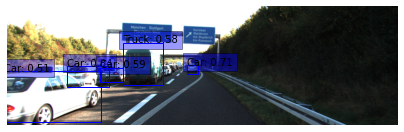

<AxesSubplot:>

In [116]:
visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

## 통합 : 자율주행 보조 시스템 만들기
---


위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어보자!

- 조건 : 
1. 입력으로 이미지 경로를 받습니다.
2. 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.   
    1) **사람이 한 명 이상 있는 경우**   
    2) **차량의 크기(width or height)가 300px이상인 경우**


위에서 info를 통해 object의 label을 확인합니다. 

- Describes the type of object: 'Car', 'Van', 'Truck','Pedestrian', 'Person_sitting', 'Cyclist'(자전거타는 사람), 'Tram', 'Misc'(기타) or 'DontCare'

#### 1. 차량의 정의 

상기 label에서 차량으로 구분할 수 있는 것은 'Car', 'Van', 'Truck' 3가지 입니다. 

하지만 **자율주행 시스템에서 차량의 크기가 300px이상을 선정하는 이유는 가까운 차량을 파악하여 멈추기 위함**이라고 생각합니다. 

그래서 차량으론 상기 3가지이지만, 리스트로 'Tram'을 추가해줍니다.

=> **차량 list = 'Car', 'Van', 'Truck', 'Tram'**


#### 2. 사람의 정의 

위의 label에서 'Pedestrian', 'Person_sitting'이 있는데 여기서 'Pedestrian'만 넣어줍니다.

In [159]:
# 학습 모델 불러오기
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints2/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

print('직접 train한 model 불러오기(epoch 3)')

직접 train한 model 불러오기(epoch 3)


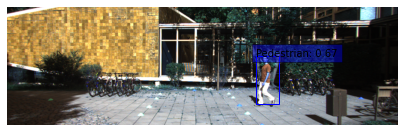

Stop


In [144]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'

def self_drive_assist(img_path, size_limit=300): 
    image = cv2.imread(img_path)
    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
    
    boxes = detections.nmsed_boxes[0][:num_detections]
    car_list = ['Car', 'Van', 'Truck', 'Tram']  
    
    for box, cls, in zip(boxes, class_names):
        # 1) 사람 유무에 따른 Go/Stop
        if cls == 'Pedestrian': 
            return "Stop"
        
        # 2) 차량 사이즈 따른 Go/Stop
        elif cls in car_list:
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            if (w >= 300 or h >= 300):
                return "Stop"
            else:
                return "Go"
        else:
            return "Go"

print(self_drive_assist(img_path))

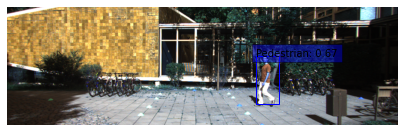

Stop


In [166]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'

def self_drive_assist2(img_path, size_limit=300): 
    image = cv2.imread(img_path)
    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
    
    boxes = detections.nmsed_boxes[0][:num_detections]
    result = "Go"
    
    for box, cls, in zip(boxes, class_names):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        if (w >= 300 or h >= 300) or (cls == 'Pedestrian'):
            result = "Stop"
            
    return result

print(self_drive_assist2(img_path))

함수에서 return을 잘쓰자!!!!

### 2. 자율주행 시스템 평가하기
---

아래 test_system()를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [167]:
def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    print('=============== 자율주행 TEST결과 확인 ===============')
    idx = 1
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
            print(f'{idx}번째 그림은 정답입니다')
        else:
            print(f'{idx}번째 그림은 오답입니다')
        idx = idx + 1
        print('======================================================')
        
    print(f"해당 시스템은 {score}점입니다.")
    
    if (score >= 90):
        print('모델을 충분히 학습시켰습니다!')
    else:
        print('모델이 충분히 학습되지 않았습니다. 더 학습시키시길 바랍니다!')


=============== 자율주행 TEST결과 확인 ===============


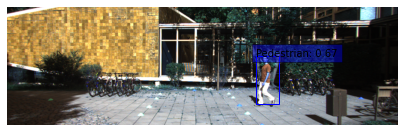

1번째 그림은 정답입니다


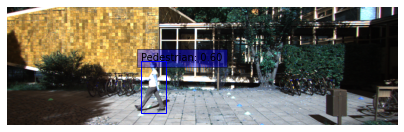

2번째 그림은 정답입니다


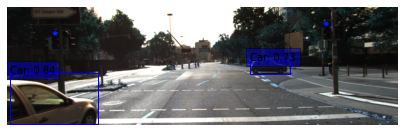

3번째 그림은 정답입니다


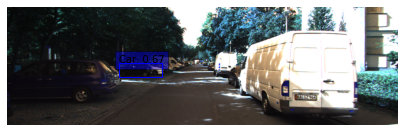

4번째 그림은 오답입니다


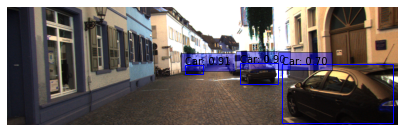

5번째 그림은 오답입니다


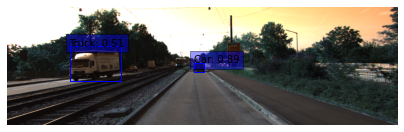

6번째 그림은 정답입니다


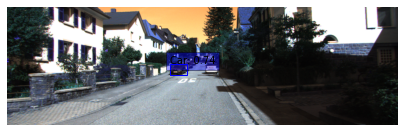

7번째 그림은 정답입니다


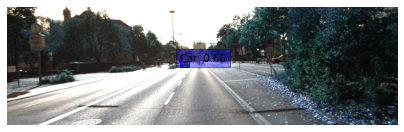

8번째 그림은 정답입니다


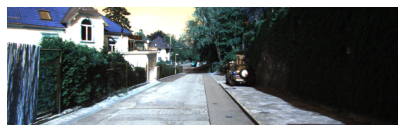

9번째 그림은 오답입니다


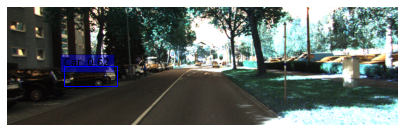

10번째 그림은 정답입니다
해당 시스템은 70점입니다.
모델이 충분히 학습되지 않았습니다. 더 학습시키시길 바랍니다!


In [148]:
test_system(self_drive_assist)

=============== 자율주행 TEST결과 확인 ===============


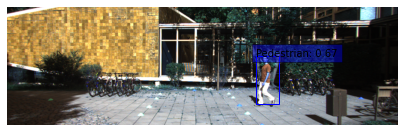

1번째 그림은 정답입니다


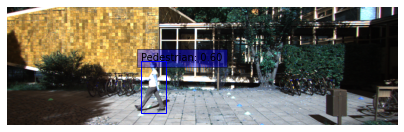

2번째 그림은 정답입니다


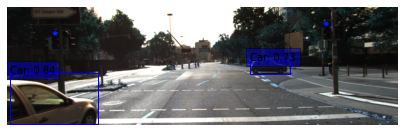

3번째 그림은 정답입니다


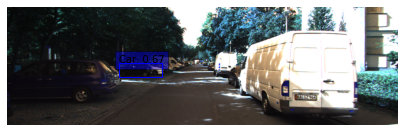

4번째 그림은 오답입니다


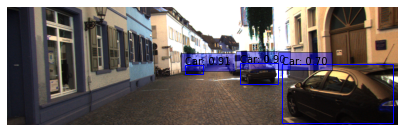

5번째 그림은 정답입니다


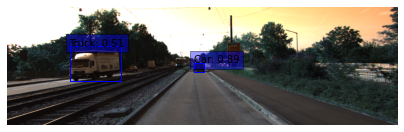

6번째 그림은 정답입니다


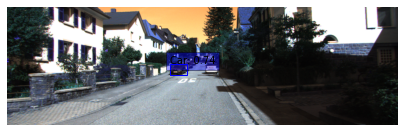

7번째 그림은 정답입니다


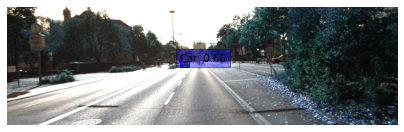

8번째 그림은 정답입니다


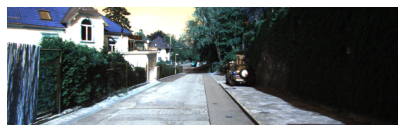

9번째 그림은 정답입니다


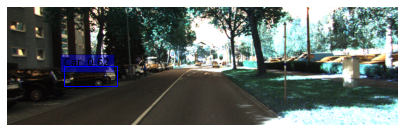

10번째 그림은 정답입니다
해당 시스템은 90점입니다.
모델을 충분히 학습시켰습니다!


In [168]:
test_system(self_drive_assist2)